<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/02_dropout_vs_mc_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Imports and Data Prep
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [2]:
# Load and preprocess Fashion-MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train[..., tf.newaxis].astype("float32") / 255.0
x_test = x_test[..., tf.newaxis].astype("float32") / 255.0

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Step 2: Build Standard Dropout Model (Dropout OFF during inference)
def build_standard_dropout_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # standard dropout
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train standard dropout model
model_standard = build_standard_dropout_model()
history_standard = model_standard.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10, batch_size=64, verbose=0
)

In [4]:
# Step 3: Build MC Dropout model (Dropout ON during inference)
class MCDropoutModel(tf.keras.Model):
    def __init__(self):
        super(MCDropoutModel, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dropout = layers.Dropout(0.5)
        self.out = layers.Dense(10, activation='softmax')

    def call(self, inputs, training=False):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dropout(x, training=True)  # keep dropout active always!
        return self.out(x)

# Instantiate, compile, and train MC Dropout model
model_mc = MCDropoutModel()
model_mc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mc = model_mc.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=10, batch_size=64, verbose=0
)


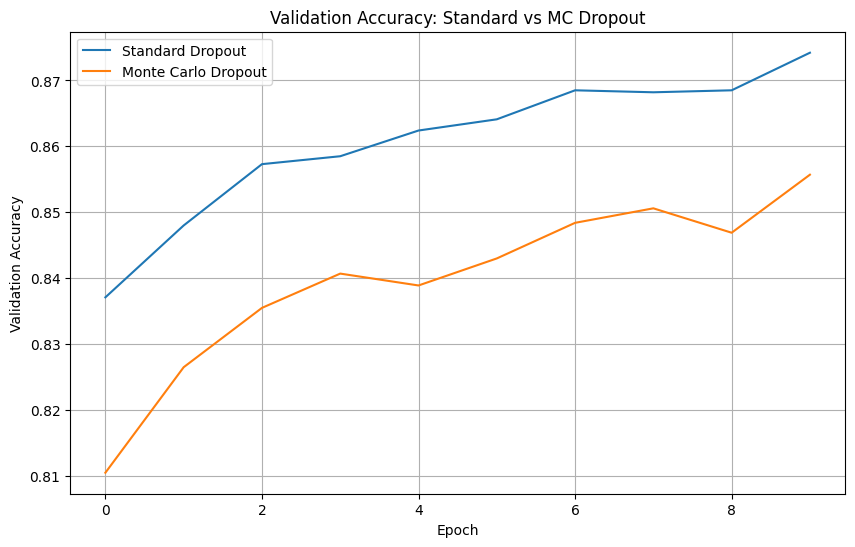

In [5]:
# Step 4: Plot Validation Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(history_standard.history['val_accuracy'], label='Standard Dropout')
plt.plot(history_mc.history['val_accuracy'], label='Monte Carlo Dropout')
plt.title("Validation Accuracy: Standard vs MC Dropout")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

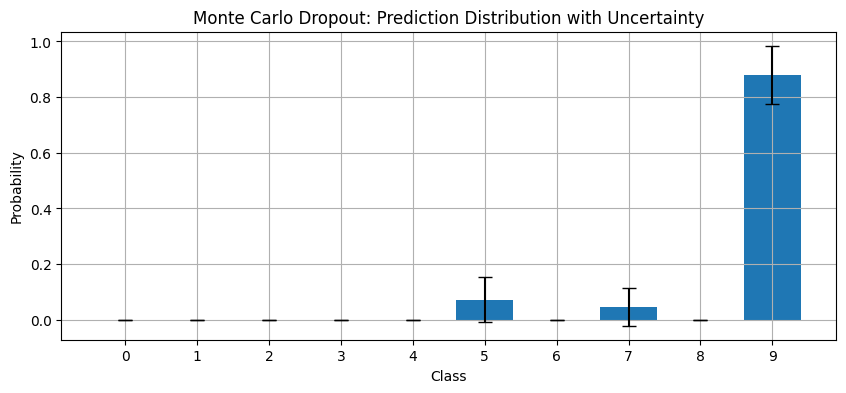

In [6]:
# Step 5: Uncertainty Estimation via MC Dropout Sampling
sample = x_test[0:1]  # one image

predictions = np.array([model_mc(sample, training=True).numpy() for _ in range(30)])
mean_probs = predictions.mean(axis=0).squeeze()
std_probs = predictions.std(axis=0).squeeze()

# Plot prediction uncertainty
plt.figure(figsize=(10, 4))
plt.bar(range(10), mean_probs, yerr=std_probs, capsize=5)
plt.title("Monte Carlo Dropout: Prediction Distribution with Uncertainty")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.xticks(range(10))
plt.grid(True)
plt.show()
